# <center>Preprocessing Data Analysis</center>

In [1]:
import numpy as np
import csv
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget          
# Changing matplotlib backend to make plots interactive. 
# If you encounter any memory trouble with it, you can remove it

from utils import *         # Local file containing all the functions that we need
import params               # Parameters file. You should tune it for your own experiment

# Run this before the sorting

### Cell 1: Create Symbolic links

As spyking circus requires a specific file format, we create here symbolic links to the raw recording file with the right Spyking circus format. This cell contains important variable for the rest of the notebook. You should check stim duration as sanity check.

In [2]:
"""
    Variables
    
    DO NOT CHANGE VALUES HERE UNLESS DEBUG/SPECIFIC USE
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""
#Link to the folder where spiking circus will look for the symbolic links "recording_0i.raw"
symbolic_link_directory = params.symbolic_link_directory

#Link to the actual raw files from the recording listed in the input_file
recording_directory     = params.recording_directory

#Loading raw recording files names
recording_names = params.recording_names

"""
    Processing
"""

recording_names = [rec.split(r'.raw')[0]+r'.raw' for rec in recording_names]
print('Number of recordings: {}\n'.format(len(recording_names)))
#Creates links
link_names, previously_existing = create_symlinks([rec for rec in recording_names], symbolic_link_directory, recording_directory)

#getting onset for next prints
onsets = {}
onsets = recording_onsets(link_names, path = symbolic_link_directory)

#Printing results
print('\nCheck that the name and the recording number match in the links file\n') 
link_names_it = link_names[:]
link_names_it.append('end')
for i in range(len(link_names_it)-1):
    print("created link {}\t{} minutes\t{}\t{}".format(
        link_names[i], 
        int((onsets[link_names_it[i+1]] - onsets[link_names_it[i]])/params.fs/60), 
        previously_existing[i],
        recording_names[i]))


"""Output :

Saved :
Symbolic links have been created

Var :
recordings_names : Ordered list of stimuli names played during experiment
link_names       : Ordered list of links names to recording files to follow spyking_circus requirements   
"""   

print('\n\t\t\t------ End Of Cell ------')

Number of recordings: 6

/!\ File /media/samuele/Samuele_2/20230303_MultiSpots/Sorting_3/recording_0.raw already exists /!\ May not be a problem if you already run this code for THIS experiment
/!\ File /media/samuele/Samuele_2/20230303_MultiSpots/Sorting_3/recording_1.raw already exists /!\ May not be a problem if you already run this code for THIS experiment
/!\ File /media/samuele/Samuele_2/20230303_MultiSpots/Sorting_3/recording_2.raw already exists /!\ May not be a problem if you already run this code for THIS experiment
/!\ File /media/samuele/Samuele_2/20230303_MultiSpots/Sorting_3/recording_3.raw already exists /!\ May not be a problem if you already run this code for THIS experiment
/!\ File /media/samuele/Samuele_2/20230303_MultiSpots/Sorting_3/recording_4.raw already exists /!\ May not be a problem if you already run this code for THIS experiment
/!\ File /media/samuele/Samuele_2/20230303_MultiSpots/Sorting_3/recording_5.raw already exists /!\ May not be a problem if you alr

### Cell 2 : Sanity checks of symlinks

#### <center>REQUIRES CELL 1 RUN</center>

Sanity checks of symlinks comparing onsets recorded from raw files and onsets recorded from symlinks. If both plots are identical, it is likely that links point to the right recording files. Otherwise, links are pointing to the wrong files. You may want to check your params.py file for a wrong directory.


Make sure both plots are identical


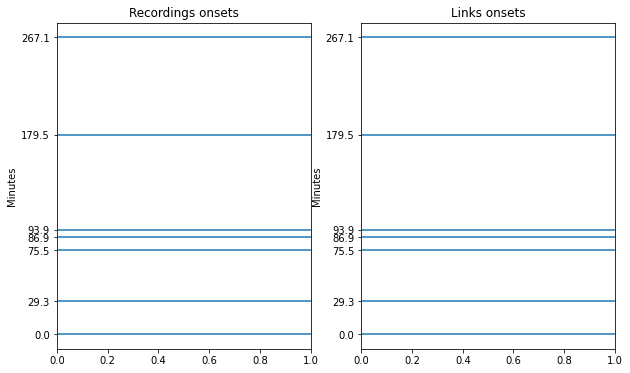


			------ End Of Cell ------


In [3]:
"""
    Variables
    
    DO NOT CHANGE VALUES HERE UNLESS DEBUG/SPECIFIC USE
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""

#Link to the folder where spiking circus will look for the symbolic links "recording_0i.raw"
symbolic_link_directory = params.symbolic_link_directory

#Link to the actual raw files from the recording listed in the input_file
recording_directory     = params.recording_directory


"""
    Processing
"""

rec_onsets  = recording_onsets(recording_names, path = recording_directory)

link_onsets = recording_onsets(link_names, path = symbolic_link_directory)


"""
    Ploting
"""
print("\nMake sure both plots are identical")
plt.ioff()
plt.close('all')
fig = plt.figure(figsize=(10,6))

# LEFT PLOT
ticks=[]
plt.subplot(1,2,1)
for rec in recording_names:
    plt.axhline(rec_onsets[rec]/params.fs/60)
    ticks.append(rec_onsets[rec]/params.fs/60)
plt.axhline(rec_onsets['end']/params.fs/60)
ticks.append(rec_onsets['end']/params.fs/60)

plt.yticks(ticks)
plt.title('Recordings onsets')
plt.ylabel('Minutes')

# RIGHT PLOT
ticks=[]
plt.subplot(1,2,2)
for rec in link_names:
    plt.axhline(link_onsets[rec]/params.fs/60)
    ticks.append(link_onsets[rec]/params.fs/60)
plt.axhline(link_onsets['end']/params.fs/60)
ticks.append(link_onsets['end']/params.fs/60)
plt.yticks(ticks)
plt.title('Links onsets')
plt.ylabel('Minutes')

plt.show(block = False)
plt.close(fig)

print('\n\t\t\t------ End Of Cell ------')

### Cell 3 : Extract the triggers

#### <center>REQUIRES CELL 1 RUN</center>

Extract triggers from either the visual or holo trigger channel. Automatic detection of Holographic recording. Check that the detection is perform on the right files. Perform triggers sanity checks for visual stimumi. You can plot them later on cell 4. Can take up to more than 1h to run all recordings depending on your experiment length.

In [4]:
"""
    Variable
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""

#name of your experiment for saving the triggers
exp = params.exp

# select MEA (3=2p room) (4=MEA1 Polycrhome)
MEA = params.MEA                       

#the optimal threshhold for detecting stimuli onsets varies with the rig
threshold  = params.threshold           

Nchannels  = params.nb_channels                #256 for standard MEA, 17 for MEA1 Polychrome

# number of triggers samples acquired per second
fs         = params.fs

# number of time points used to check if a recording is holographic or not
probe_size = params.probe_size

#The folder in which you want your triggers to be saved 
triggers_directory = params.triggers_directory

#Channel recording triggers in case of holographic stimuli
holo_channel_id   = params.holo_channel_id

#Channel recording triggers in case of visual stimuli
visual_channel_id = params.visual_channel_id 

"""
    Inputs
"""

#you can decide here to extract the triggers only for some recordings. List their indexes here (starting from 0).
select_rec = []    # do only measurement N, put [] or the complet list to call all of them


"""
    Processing
"""

for rec in range(len(link_names)):

    if select_rec:
        if rec not in select_rec: continue
    
    print('\n-------------   Processing recording {} out of {}   -------------\n'.format(rec+1,len(link_names)))

    # Creating all files path
    input_file    = os.path.join(symbolic_link_directory,link_names[rec])
    trigger_file  = os.path.join(triggers_directory,'{}_{}_triggers.pkl'.format(exp,recording_names[rec]))
    data_file     = os.path.join(triggers_directory,'{}_{}_triggers_data.pkl'.format(exp,recording_names[rec]))
    
    print('The triggers are extracted from the sorting file:\t{}\nand the results will be saved at:\t\t\t{}'.format(recording_names[rec],trigger_file))

    if is_holographic_rec(input_file): 
        #in this case the stimulus was holograpic
        print(" /!\ HOLOGRAPHIC Recording /!\ ")
        channel_id   = holo_channel_id
        trigger_type = 'holo'
    else: 
        #in this other case the stimulus was visual
        print(" /!\ VISUAL Recording /!\ ")
        channel_id   = visual_channel_id        
        trigger_type = 'visual'
    
    #Processing of data calling utils functions
    print("Loading Data...")
    data, t_tot    = load_data(input_file, channel_id = channel_id )  #MANUALLY CHANGE HERE IF THE CHANNEL IS 
                                                                     #AUTHOMATICALLY MISDETECTED. IF SO IT SHOULD 
                                                                    #BE BECAUSE OF ALIASING OR BAD TRIGGER QUALITY
    indices        = detect_onsets(data,threshold)
    indices_errors = run_minimal_sanity_check(indices, stim_type = trigger_type)
    
    #Saving data using utils function save_obj
    save_obj({'indices':indices,'duration':t_tot,'trigger_type':trigger_type,'indice_errors':indices_errors}, trigger_file )
    save_obj(data,data_file)


"""
    Output
    
    Saved in triggers_directory :

{experience_name}_{link_file_name}_triggers.pkl (dict) : 
    keys 'indices' --> detected triggers indices, 
         'duration' --> the stimuli duration, 
         'trigger_type' --> the detection visual or holo stimuli, 
         'indice_errors' --> triggers violating sanity check 
         
{experience_name}_{link_file_name}_triggers_data.pkl (numpy array) : raw signal recorded on the trigger channel

"""
print('\n\t\t\t------ End Of Cell ------')


-------------   Processing recording 1 out of 6   -------------

The triggers are extracted from the sorting file:	00_CheckerboardAcclim_25D50%_30x20_30Hz.raw
and the results will be saved at:			/media/samuele/Samuele_2/20230303_MultiSpots/Analysis/trigs/20230303_MultiSpots_00_CheckerboardAcclim_25D50%_30x20_30Hz.raw_triggers.pkl
Checking if holographic recording...	 /!\ HOLOGRAPHIC Recording /!\ 
Loading Data...


  0%|          | 0/35136000 [00:00<?, ?it/s]

No sanity checks done on holographic stimulus

-------------   Processing recording 2 out of 6   -------------

The triggers are extracted from the sorting file:	01_Checkerboard_25D50%_20x30_30Hz.raw
and the results will be saved at:			/media/samuele/Samuele_2/20230303_MultiSpots/Analysis/trigs/20230303_MultiSpots_01_Checkerboard_25D50%_20x30_30Hz.raw_triggers.pkl
Checking if holographic recording...	 /!\ HOLOGRAPHIC Recording /!\ 
Loading Data...


  0%|          | 0/55416000 [00:00<?, ?it/s]

No sanity checks done on holographic stimulus

-------------   Processing recording 3 out of 6   -------------

The triggers are extracted from the sorting file:	02_Chirp_20reps_25ND50%_50Hz.raw
and the results will be saved at:			/media/samuele/Samuele_2/20230303_MultiSpots/Analysis/trigs/20230303_MultiSpots_02_Chirp_20reps_25ND50%_50Hz.raw_triggers.pkl
Checking if holographic recording...	 /!\ HOLOGRAPHIC Recording /!\ 
Loading Data...


  0%|          | 0/13778000 [00:00<?, ?it/s]

No sanity checks done on holographic stimulus

-------------   Processing recording 4 out of 6   -------------

The triggers are extracted from the sorting file:	03_DG_25ND50%_2sT_50Hz.raw
and the results will be saved at:			/media/samuele/Samuele_2/20230303_MultiSpots/Analysis/trigs/20230303_MultiSpots_03_DG_25ND50%_2sT_50Hz.raw_triggers.pkl
Checking if holographic recording...	 /!\ HOLOGRAPHIC Recording /!\ 
Loading Data...


  0%|          | 0/8368000 [00:00<?, ?it/s]

No sanity checks done on holographic stimulus

-------------   Processing recording 5 out of 6   -------------

The triggers are extracted from the sorting file:	04_MultiSpots_50reps_25ND50%_40Hz.raw
and the results will be saved at:			/media/samuele/Samuele_2/20230303_MultiSpots/Analysis/trigs/20230303_MultiSpots_04_MultiSpots_50reps_25ND50%_40Hz.raw_triggers.pkl
Checking if holographic recording...	 /!\ HOLOGRAPHIC Recording /!\ 
Loading Data...


  0%|          | 0/102672000 [00:00<?, ?it/s]

No sanity checks done on holographic stimulus

-------------   Processing recording 6 out of 6   -------------

The triggers are extracted from the sorting file:	05_MultiSpots_25ND50%_40Hz.raw
and the results will be saved at:			/media/samuele/Samuele_2/20230303_MultiSpots/Analysis/trigs/20230303_MultiSpots_05_MultiSpots_25ND50%_40Hz.raw_triggers.pkl
Checking if holographic recording...	 /!\ HOLOGRAPHIC Recording /!\ 
Loading Data...


  0%|          | 0/105160000 [00:00<?, ?it/s]

No sanity checks done on holographic stimulus

			------ End Of Cell ------


### CELL 4 : Plots triggers for sanity check

#### <center>REQUIRES CELL 1 RUN & CELL 3 RUN AT LEAST ONCE FOR THIS EXPERIMENT </center>

Plots the raw trigger signal with the detected triggers and the errors detected. Independently, plots also the detected triggers, should be a perfect diagonal. Third, plots the number of time points gap to the most common trigger duration (ie theoretical_time_per_frame +- ploted value).

#### <center>/!\/!\/!\ Caution on memory leaks /!\/!\/!\ </center>

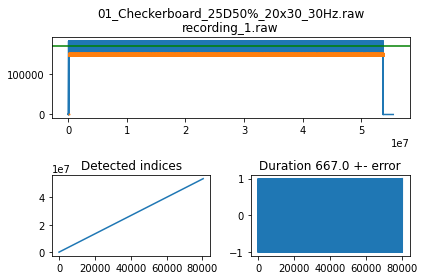


			------ End Of Cell ------


In [8]:
"""
    Variable
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""

#Experiment name
exp = params.exp

# Optimal threshhold for detecting stimuli onsets varies with the rig
threshold  = params.threshold 

# Directory where plots will be saved
output_directory = params.output_directory


"""
    Inputs
"""

#Select the recordings number you want to plot (starting from 0)
recordings = [1]

#Set True if you want the plots to be saved
save = False

#Define your x-axis ploting window in a tuple (x-min,x-max). Set False to plot the complete data
ploting_range = False


"""
    Ploting
"""

plt.ioff()
plt.close('all')
for rec in recordings:
    
    # Loading data from pickle files created in cell 3
    data    = np.array(load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers_data.pkl'.format(exp,recording_names[rec])))))
    extracted = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,recording_names[rec]))))
    err = extracted['indice_errors']
    indices = extracted['indices']
    
    # If ploting range is a tuple, reduce the plot to indices between both values of the tuple
    if ploting_range :
        indices = indices[np.logical_and(indices > ploting_range[0], indices < ploting_range[1])]
        data    = data[np.logical_and(np.array(range(len(data))) > ploting_range[0], np.array(range(len(data))) < ploting_range[1])]
        err     = err[np.logical_and(err > ploting_range[0], err < ploting_range[1])]
    
    plt.figure()
    
    # Top plot with raw trigger signal, threshold of detection, detected triggers and wrong triggers
    plt.subplot(2,1,1)
    plt.title('{}\n{}'.format(recording_names[rec],link_names[rec]))
    
    plt.plot(data)
    plt.plot(indices,data[indices],'.',markersize=2,zorder=10)

    plt.axhline(threshold, color='green')
    plt.scatter(err,data[err], color='red', marker='x',zorder = 15)
    
    # Bottom left plot of triggers indices. Shoule be a perfect diagonal
    plt.subplot(2,2,3)
    plt.plot(indices)
    plt.title('Detected indices')
    
    # Bottom right plot of relative error gap between detect time of frame and mean frame time
    plt.subplot(2,2,4)
    plt.plot(np.diff(np.diff(indices)))
    plt.title('Duration {} +- error'.format(np.round(np.mean(np.diff(indices)))))
    
    plt.tight_layout()
    plt.show(block = False)
    
    plt.clf()    #Does this save the day??

    plt.close()
    # Saving plot if needed
    if save:
        fig_name = os.path.join(output_directory,r'{}_{}.png'.format(recording_names[rec],link_names[rec]))
        plt.savefig(fig_name)


"""
    Output
    
    if save == True
    
    {recording_file_name}_{link_file_name}.png : Plots for a given recording file

"""

print('\n\t\t\t------ End Of Cell ------')

### Cell 5 : Dead times file creation

#### <center>REQUIRES CELL 1 RUN & CELL 3 RUN AT LEAST ONCE FOR THIS EXPERIMENT </center>

Run minimal sanity check on visual triggers and create the dead times in sec for holographic stimuli. If you only have visual triggers, running this cell isn't mandatory, it only provides a repeated sanity check for visual stims...

Recording 0 :	0_CheckerboardAcclim_40ND20p_20x30_30Hz.raw
Minimal sanity checks : Ok on all 35572 triggers


Recording 1 detected as holographic :	1_Checkerboard_30x20_30nd.30p.raw
Number of triggers to be added to dead times file : 0


Recording 2 :	1_Checkerboard_40ND20p_20x0_30Hz.raw
Minimal sanity checks : Ok on all 47691 triggers


Recording 3 :	2_Euler_40ND20%_40Hz.raw
Minimal sanity checks : Ok on all 30000 triggers


Recording 4 :	3_Flicker_BeforeDrugs_40ND5p_1Hz.raw
Minimal sanity checks : Ok on all 86 triggers


Recording 5 :	4_Flicker_AfterDrugs_40ND5p_1Hz.raw
Minimal sanity checks : Ok on all 95 triggers


Recording 6 :	5_OptoStim1_20ND5p_1Hz.raw
Minimal sanity checks : Ok on all 115 triggers


Recording 7 :	6_OptoStim1_20ND20p_1Hz.raw
Minimal sanity checks : Ok on all 61 triggers


Recording 8 detected as holographic :	7_HoloStim_SingleCell.raw
Number of triggers to be added to dead times file : 300


Recording 9 detected as holographic :	8_HoloStim_SingleCell.raw
Number o

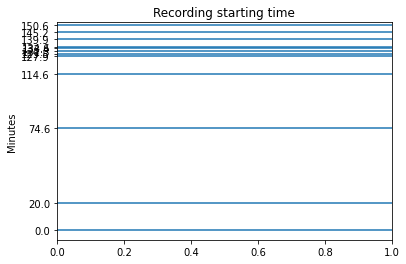


			------ End Of Cell ------


In [6]:
"""
    Variable
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""

#name of your experiment for saving the triggers
exp = params.exp

#The folder in which you saved your triggers
triggers_directory = params.triggers_directory

#The folder containing raw recording files
recoding_directory = params.recording_directory

# Directory where dead_times file will be saved
output_directory = params.output_directory
"""
    Processing
"""

rec_onsets    = recording_onsets(recording_names, path = recoding_directory)  

holo_onsets   = []
holo_triggers = []
for rec in range(len(recording_names)):
    
    #Loading data
    trig_data = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,recording_names[rec]))))
    
    
    if trig_data['trigger_type']=='holo':
        #If recording was detected as holographic
        print('Recording {} detected as holographic :\t{}'.format(rec, recording_names[rec]))
        holo_onsets.append(rec_onsets[recording_names[rec]])
        holo_triggers.append(trig_data['indices'])
        print('Number of triggers to be added to dead times file : {}'.format(len(trig_data['indices'])))
        
    else:
        #Otherwise it is considered as visual
        print('Recording {} :\t{}'.format(rec, recording_names[rec]))
        err = run_minimal_sanity_check(trig_data['indices'])    
    print('\n')

print('Writting dead times file for {} holographic recordings...'.format(len(holo_triggers)))
#Writting .dead file using utils function
write_dead_times_file(holo_triggers,holo_onsets, output_directory)


"""
    Ploting
"""

#Potting once more the recordings onsets similarly to cell 2
ticks=[]
plt.ioff()
plt.close('all')
plt.figure() 
for rec in range(len(recording_names)):
    plt.axhline(rec_onsets[recording_names[rec]]/params.fs/60)
    ticks.append(rec_onsets[recording_names[rec]]/params.fs/60)
    
plt.yticks(ticks)
plt.title('Recording starting time')
plt.ylabel('Minutes')
plt.show()


"""
    Output
    
    {recording_file_name}_dead_times.dead : dead time file given times to exclude in spyking circus

"""

print('\n\t\t\t------ End Of Cell ------')

# <center>/!\/!\/!\ Run this after the sorting /!\/!\/!\ </center>

### Cell 6 : Creating all clusters rasters plots

#### <center>REQUIRES CELL 1 RUN</center>

Run after automatic sorting to help with manual sorting. Saves all automatic clusters' rasters on the repeated checherboard in the phy directory. You can run this several times during sorting to make new clusters rasters. Can take few sec per cluster...

In [9]:
"""
    Variable
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""
#length of each sequence composed of half repeated sequence and half random sequence

nb_frames_by_sequence = params.nb_frames_by_sequence

# Name of your experiment
exp = params.exp

#Path to the folder with the phy output
phy_directory = params.phy_directory

#Path to raw recording files
recoding_directory = params.recording_directory

#Frequency of sampling of the mea
fs = params.fs

"""
    Input
"""
#Number of the checkerboard recording of choice (start from zero)
check_recording_number = 0

#Checkerboard frequency in Hz
stimulus_frequency = 30

"""
    Processing
"""
###################################
#### Loading phy clusters info ####
###################################



rec_onsets = recording_onsets(recording_names, path = recording_directory)  

# Get cells index and number
cluster_number , good_clusters = extract_cluster_groups(phy_directory)

# Extract the spike times from the spike sorting files. This can take a few minutes.
print('Spike extraction: ')
all_spike_times = extract_all_spike_times_from_phy(phy_directory)

# create a dictionary with another dictionary for each cluster
all_neurons_data = split_spikes_by_recording(all_spike_times, cluster_number, rec_onsets)


#############################
#### Making raster plots ####
#############################

checkerboard_name = recording_names[check_recording_number]

checkerboard_spikes = get_recording_spikes(checkerboard_name, all_neurons_data)

trig_data = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,checkerboard_name))))
triggers = trig_data['indices']/fs
raster_data = {}

print('Building Raster plots : ')
for (cell_nb, spike_times) in tqdm(checkerboard_spikes.items()):
    # Align triggers and spike times
    aligned_triggers, aligned_spike_times = align_triggers_spikes(triggers, spike_times)
    
    # Get rasters on repeated sequence
    raster_data[cell_nb] = build_rasters(aligned_spike_times, aligned_triggers, stim_frequency = stimulus_frequency)


"""
    Saving
"""

#Save all clusters rasters plots    
fig_directory = os.path.normpath(os.path.join(phy_directory,r'clusters_rasters_{}'.format(check_recording_number)))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

    
print("Saving rasters plots of all clusters :")
for cell_nb in tqdm(raster_data.keys()):
    fig, axs = plt.subplots(nrows = 2,ncols = 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,10))

    plt.suptitle(f'Cell {cell_nb}')

    ax_rast = axs[0]
    ax_rast.eventplot(raster_data[cell_nb]["spike_trains"])
    ax_rast.set(title = "Raster plot", ylabel='N Repetitions')

    ax_psth = axs[1]
    width = (raster_data[cell_nb]["repeated_sequences_times"][0][0]/600)
    ax_psth.bar(np.linspace(0,raster_data[cell_nb]["repeated_sequences_times"][0][0],int(nb_frames_by_sequence/2))+width/2, raster_data[cell_nb]["psth"], width=1.3*width)
    ax_psth.set(xlabel='Time in sec', ylabel='Firing rate (spikes/s)')

    plt.subplots_adjust(wspace=0, hspace=0)
    fig_file = os.path.normpath(os.path.join(fig_directory,f'Cluster_{cell_nb}.png'))
    plt.savefig(fig_file, dpi=fig.dpi)
    plt.clf()
    plt.close()
    
"""
    Output
    
    Save :
    
    ""{phy_directory}/clusters_rasters/Cluster_{Cluster_number}.png" for each found clusters in phy's files
"""    

print('\n\t\t\t------ End Of Cell ------')

Spike extraction: 


  0%|          | 0/23011797 [00:00<?, ?it/s]

  0%|          | 0/578 [00:00<?, ?it/s]

Building Raster plots : 


  0%|          | 0/578 [00:00<?, ?it/s]

Saving rasters plots of all clusters :


  0%|          | 0/578 [00:00<?, ?it/s]


			------ End Of Cell ------


### Cell 7 : Extract data per neurons

#### <center>REQUIRES CELL 1 RUN</center>

Extract all data from phy numpy variables. Create&save a dictionnary containg spikes times in sec for each neuron splited by recording. Depending on your experiment, this can take severeal minutes.

In [10]:
"""
    Variable
    
    You will find here all variables used in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""

# Name of your experiment
exp = params.exp

#Path to the folder with the phy output
phy_directory = params.phy_directory

#Path to where data should be saved
output_directory = params.output_directory

#Path to rax recording files
recoding_directory = params.recording_directory

#Frequency of sampling of the mea
fs = params.fs


"""
    Processing
"""

rec_onsets    = recording_onsets(recording_names, path = recording_directory)  

# Get cells index and number
cluster_number , good_clusters = extract_cluster_groups(phy_directory)
print("There are {} good clusters ({} clusters in total)\n".format(len(good_clusters), len(cluster_number)))


# Extract the spike times from the spike sorting files. This can take a few minutes.
print('Spike extraction: ')
all_spike_times = extract_all_spike_times_from_phy(phy_directory)

print('\n')
print('Spike division in recordings per neuron:')
# create a dictionary with another dictionary for each good cluster
good_data = split_spikes_by_recording(all_spike_times, good_clusters, rec_onsets)


# Save the spike data. This can take a few minutes.
good_data_file_name = os.path.join(output_directory,r'{}_fullexp_neurons_data.pkl'.format(exp))
save_obj(good_data,good_data_file_name)

"""
    Output
    
    data (dict) : key 'cluster_id' --> (dict) key 'recording_name' --> This neuron & this recording spikes times in sec

"""

print('\n\t\t\t------ End Of Cell ------')

There are 339 good clusters (578 clusters in total)

Spike extraction: 


  0%|          | 0/23011797 [00:00<?, ?it/s]



Spike division in recordings per neuron:


  0%|          | 0/339 [00:00<?, ?it/s]


			------ End Of Cell ------
